## Carga de los datos de esqueletos 2D

In [62]:
import pickle

pkl_path = 'ucf101_2d.pkl'

# Cargar el archivo .pkl con los datos de esqueletos
with open(pkl_path, 'rb') as file:
    data = pickle.load(file)

# Claves principales del diccionario cargado
print("Claves del diccionario de datos:", data.keys())
print("Número total de secuencias en el dataset:", len(data['annotations']))

Claves del diccionario de datos: dict_keys(['split', 'annotations'])
Número total de secuencias en el dataset: 13320


## Preprocesamiento de las secuencias de esqueletos

In [75]:
import numpy as np
import math
from sklearn.model_selection import train_test_split

# 5 clases de interés
clases_interes = ["ApplyEyeMakeup", "ApplyLipstick",
                  "BlowDryHair", "BrushingTeeth", "HeadMassage"]

# Mapeo de nombre de clase a etiqueta numérica 0-4
map_clase_a_label = {clase: idx for idx, clase in enumerate(clases_interes)}

# número de frames
L = 300

X_list = []  # lista para secuencias de entrada
Y_list = []  # lista para etiquetas (numéricas)

for ann in data['annotations']:
    # Id del video
    video_id = ann['frame_dir']
    # Verificar si esta anotación corresponde a alguna de las 5 clases de interés
    clase_actual = None
    for clase in clases_interes:
        if clase in video_id:
            clase_actual = clase
            break
    if clase_actual is None:
        continue

    # Obtener la etiqueta numérica asignada a esta clase
    label = map_clase_a_label[clase_actual]

    # Extraer la secuencia de keypoints (esqueletos)
    # Formato original: [M, T, V, C] (personas, frames, puntos, coordenadas)
    kp_seq = ann['keypoint']
    # Tomamos solo la primera persona si hay más de una
    kp_seq = kp_seq[0]  # ahora (T, V, C)
    T = kp_seq.shape[0]  # número de frames en esta secuencia

    # Normalizar coordenadas (x,y) usando el tamaño de imagen original
    height, width = ann['img_shape']  # (alto, ancho)
    kp_seq = kp_seq.astype(np.float32)
    kp_seq[..., 0] /= width
    kp_seq[..., 1] /= height

    # Reformar la secuencia a 2D: frames x (V*C)
    V = kp_seq.shape[1]  # número de puntos (17)
    C = kp_seq.shape[2]  # número de coordenadas (2)
    features = V * C     # características por frame (34)
    seq_2d = kp_seq.reshape(T, features)  # secuencia de forma (T, 34)

    # Asegurar longitud fija L mediante truncamiento o padding con ceros
    if T > L:
        # Truncar la secuencia si es más larga que L
        seq_2d = seq_2d[:L]
    elif T < L:
        # Rellenar la secuencia con ceros para alargarla hasta L
        pad_len = L - T
        pad = np.zeros((pad_len, seq_2d.shape[1]), dtype=seq_2d.dtype)
        seq_2d = np.concatenate([seq_2d, pad], axis=0)

    # Listas de datos procesados
    X_list.append(seq_2d)
    Y_list.append(label)

# Convertir listas a arrays numpy
X_array = np.array(X_list)   # (num_secuencias, L, 34)
Y_array = np.array(Y_list)   # etiquetas numéricas

print("Total de secuencias seleccionadas (5 clases):", X_array.shape[0])
print("Dimensión de cada secuencia de entrada:", X_array.shape)  # (N, 300, 34)

# Dividir en entrenamiento, validación y prueba (70%, 15%, 15%)
X_train, X_temp, Y_train, Y_temp = train_test_split(
    X_array, Y_array, test_size=0.30, stratify=Y_array, random_state=42
)
X_val, X_test, Y_val, Y_test = train_test_split(
    X_temp, Y_temp, test_size=0.50, stratify=Y_temp, random_state=42
)

print(f"Conjunto de entrenamiento: {X_train.shape[0]} secuencias")
print(f"Conjunto de validación: {X_val.shape[0]} secuencias")
print(f"Conjunto de prueba: {X_test.shape[0]} secuencias")

# Verificar distribución de clases
import collections
print("Distribución de clases en entrenamiento:", collections.Counter(Y_train))
print("Distribución de clases en validación:", collections.Counter(Y_val))
print("Distribución de clases en prueba:", collections.Counter(Y_test))


Total de secuencias seleccionadas (5 clases): 668
Dimensión de cada secuencia de entrada: (668, 300, 34)
Conjunto de entrenamiento: 467 secuencias
Conjunto de validación: 100 secuencias
Conjunto de prueba: 101 secuencias
Distribución de clases en entrenamiento: Counter({np.int64(4): 103, np.int64(0): 101, np.int64(3): 92, np.int64(2): 91, np.int64(1): 80})
Distribución de clases en validación: Counter({np.int64(0): 22, np.int64(4): 22, np.int64(2): 20, np.int64(3): 19, np.int64(1): 17})
Distribución de clases en prueba: Counter({np.int64(0): 22, np.int64(4): 22, np.int64(3): 20, np.int64(2): 20, np.int64(1): 17})


# BASELINE
## Modelo baseline (LSTM simple)

Como línea base se utiliza un modelo LSTM muy sencillo, con una sola capa LSTM de 32 unidades y una capa densa de salida con 5 neuronas (una por cada clase). Este modelo tiene aproximadamente 8.7k parámetros y sirve como referencia para comparar las mejoras posteriores.


In [64]:
# Importar TensorFlow y módulos de Keras
import tensorflow as tf
from tensorflow.keras import layers, models

# Clases de interés (subconjunto de 5 clases)
clases_interes = ["ApplyEyeMakeup", "ApplyLipstick",
                  "BlowDryHair", "BrushingTeeth", "HeadMassage"]
num_classes = len(clases_interes)  # 5

# Hiperparámetros del input
L = 300           # longitud de secuencia (fotogramas) fija
num_features = 34 # características por frame (17 articulaciones × 2 coordenadas)

# Definir el modelo baseline: una sola capa LSTM básica
model_baseline = models.Sequential()
model_baseline.add(layers.Input(shape=(L, num_features)))
model_baseline.add(layers.Masking(mask_value=0.0))
model_baseline.add(layers.LSTM(32, activation='tanh'))
model_baseline.add(layers.Dense(num_classes, activation='softmax'))


# Compilar con entropía cruzada categórica y optimizador Adam
model_baseline.compile(loss='categorical_crossentropy',
                       optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
                       metrics=['accuracy'])

# Resumen de la arquitectura
model_baseline.summary()

Model: "sequential_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ masking (Masking)               │ (None, 300, 34)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_13 (LSTM)                  │ (None, 32)             │         8,576 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 5)              │           165 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 8,741 (34.14 KB)

 Trainable params: 8,741 (34.14 KB)

 Non-trainable params: 0 (0.00 B)

In [65]:
from tensorflow.keras.callbacks import EarlyStopping
early_stop = EarlyStopping(
    monitor='val_accuracy',
    mode='max',
    patience=3,
    restore_best_weights=True
)

history = model_baseline.fit(
    X_train, Y_train_enc,
    validation_data=(X_val, Y_val_enc),
    epochs=20,
    batch_size=32,
    callbacks=[early_stop]
)

Epoch 1/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 6s 190ms/step - accuracy: 0.2567 - loss: 1.6432 - val_accuracy: 0.3800 - val_loss: 1.5588
Epoch 2/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 3s 206ms/step - accuracy: 0.3293 - loss: 1.5463 - val_accuracy: 0.3900 - val_loss: 1.4648
Epoch 3/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 2s 141ms/step - accuracy: 0.3658 - loss: 1.4480 - val_accuracy: 0.4700 - val_loss: 1.2993
Epoch 4/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 2s 143ms/step - accuracy: 0.4166 - loss: 1.3182 - val_accuracy: 0.4900 - val_loss: 1.2838
Epoch 5/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 2s 141ms/step - accuracy: 0.4355 - loss: 1.2640 - val_accuracy: 0.4400 - val_loss: 1.2488
Epoch 6/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 2s 140ms/step - accuracy: 0.4776 - loss: 1.1872 - val_accuracy: 0.5000 - val_loss: 1.1853
Epoch 7/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 3s 210ms/step - accuracy: 0.4877 - loss: 1.2027 - val_accuracy: 0.5500 - val_loss: 1.1515
Epoch 8/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 4s 144ms/step - accuracy: 0.4924 - loss: 1.1830 - val_accuracy: 0.

In [66]:
import numpy as np

val_acc = history.history['val_accuracy']
best_epoch = np.argmax(val_acc)

print("Mejor época:", best_epoch + 1)
print("Mejor val_accuracy:", val_acc[best_epoch])

Mejor época: 10
Mejor val_accuracy: 0.5899999737739563


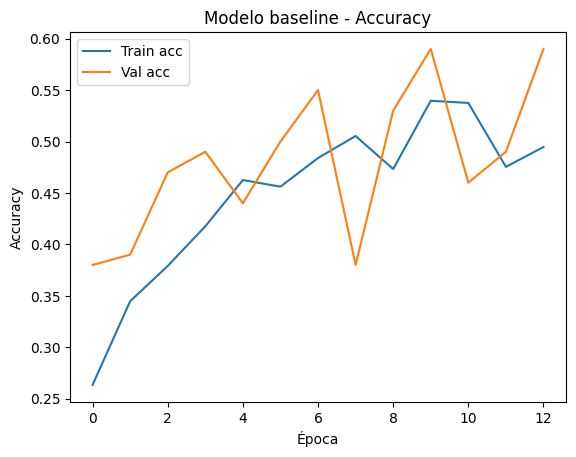

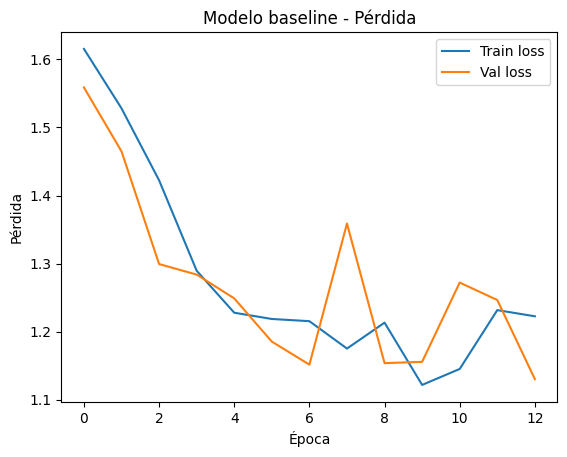

In [67]:
import matplotlib.pyplot as plt

plt.figure()
plt.plot(history.history['accuracy'], label='Train acc')
plt.plot(history.history['val_accuracy'], label='Val acc')
plt.xlabel('Época')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Modelo baseline - Accuracy')

plt.figure()
plt.plot(history.history['loss'], label='Train loss')
plt.plot(history.history['val_loss'], label='Val loss')
plt.xlabel('Época')
plt.ylabel('Pérdida')
plt.legend()
plt.title('Modelo baseline - Pérdida')
plt.show()


In [68]:
loss_base_test, acc_base_test = model_baseline.evaluate(X_test, Y_test_enc, verbose=0)
print(acc_base_test)

0.5841584205627441


# MEJORADO
## Modelo mejorado (LSTM profundo con Dropout)

A partir del baseline se propone un modelo más profundo con dos capas LSTM de 64 unidades cada una y capas Dropout intermedias para reducir el sobreajuste. Este modelo tiene ~58k parámetros y mayor capacidad para capturar la dinámica temporal de las acciones.

## Definición del modelo LSTM

In [69]:
import tensorflow as tf
from tensorflow.keras import layers, models

# Convertir las etiquetas a one-hot
Y_train_enc = tf.keras.utils.to_categorical(Y_train, num_classes=len(clases_interes))
Y_val_enc   = tf.keras.utils.to_categorical(Y_val, num_classes=len(clases_interes))
Y_test_enc  = tf.keras.utils.to_categorical(Y_test, num_classes=len(clases_interes))

# Definir el modelo LSTM
model = models.Sequential()
model.add(layers.Input(shape=(L, 34)))
model.add(layers.Masking(mask_value=0.0))  # ignora frames rellenos de ceros
# Primera capa LSTM
model.add(layers.LSTM(64, return_sequences=True, activation='tanh'))
model.add(layers.Dropout(0.5))
# Segunda capa LSTM
model.add(layers.LSTM(64, activation='tanh'))
model.add(layers.Dropout(0.5))
# Capa de salida clasificador
model.add(layers.Dense(len(clases_interes), activation='softmax'))

# Compilar el modelo con pérdida de entropía cruzada categórica y optimizador Adam
model.compile(loss='categorical_crossentropy',
              optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              metrics=['accuracy'])

# resumen
model.summary()


Model: "sequential_10"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ masking_1 (Masking)             │ (None, 300, 34)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_14 (LSTM)                  │ (None, 300, 64)        │        25,344 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 300, 64)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_15 (LSTM)                  │ (None, 64)             │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 5)              │           325 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 58,693 (229.27 KB)

 Trainable params: 58,693 (229.27 KB)

 Non-trainable params: 0 (0.00 B)

## Entrenamiento del modelo

In [70]:
# Definir early stopping
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Entrenar el modelo
history_mejorado = model.fit(X_train, Y_train_enc,
                    epochs=50,
                    batch_size=32,
                    validation_data=(X_val, Y_val_enc),
                    callbacks=[early_stop],
                    verbose=1)

Epoch 1/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 14s 441ms/step - accuracy: 0.2048 - loss: 1.6142 - val_accuracy: 0.5000 - val_loss: 1.5058
Epoch 2/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 7s 478ms/step - accuracy: 0.3709 - loss: 1.4591 - val_accuracy: 0.5200 - val_loss: 1.2343
Epoch 3/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 10s 488ms/step - accuracy: 0.4768 - loss: 1.2454 - val_accuracy: 0.5700 - val_loss: 1.1279
Epoch 4/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 6s 406ms/step - accuracy: 0.4483 - loss: 1.2049 - val_accuracy: 0.5600 - val_loss: 1.1151
Epoch 5/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 11s 449ms/step - accuracy: 0.5098 - loss: 1.1690 - val_accuracy: 0.6400 - val_loss: 1.0558
Epoch 6/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 6s 433ms/step - accuracy: 0.5869 - loss: 1.1203 - val_accuracy: 0.5400 - val_loss: 1.1566
Epoch 7/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 7s 441ms/step - accuracy: 0.5181 - loss: 1.1443 - val_accuracy: 0.5900 - val_loss: 1.0783
Epoch 8/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 11s 482ms/step - accuracy: 0.5749 - loss: 1.0523 - val_accuracy

## Gráficas

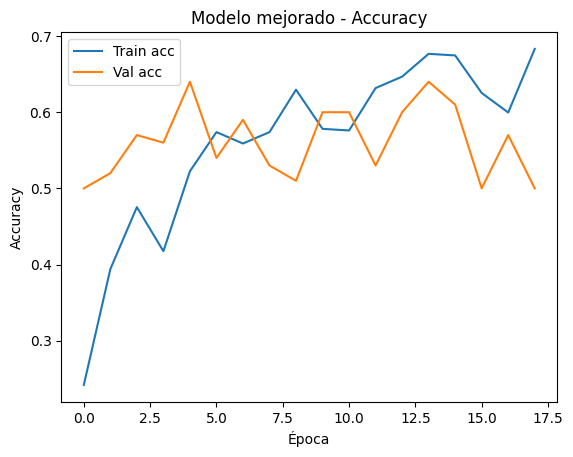

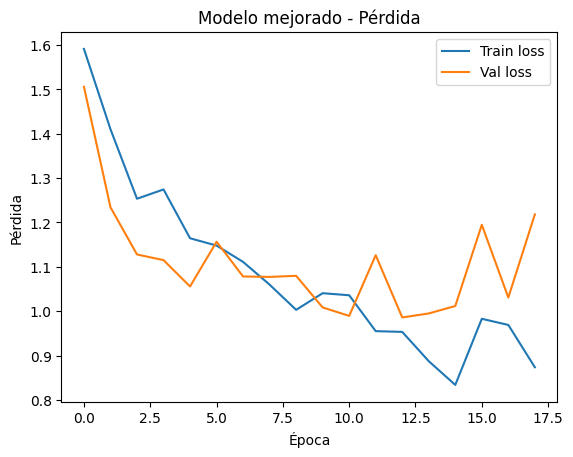

In [71]:
import matplotlib.pyplot as plt

plt.figure()
plt.plot(history_mejorado.history['accuracy'], label='Train acc')
plt.plot(history_mejorado.history['val_accuracy'], label='Val acc')
plt.xlabel('Época')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Modelo mejorado - Accuracy')
plt.show()

plt.figure()
plt.plot(history_mejorado.history['loss'], label='Train loss')
plt.plot(history_mejorado.history['val_loss'], label='Val loss')
plt.xlabel('Época')
plt.ylabel('Pérdida')
plt.legend()
plt.title('Modelo mejorado - Pérdida')
plt.show()

## Evaluación del modelo en el conjunto de prueba

Precisión en el conjunto de prueba: 67.33%
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 205ms/step
Matriz de confusión (como tabla):
 [[16  1  2  1  2]
 [ 7  7  1  2  0]
 [ 2  0 12  2  4]
 [ 0  2  1 14  3]
 [ 0  0  3  0 19]]


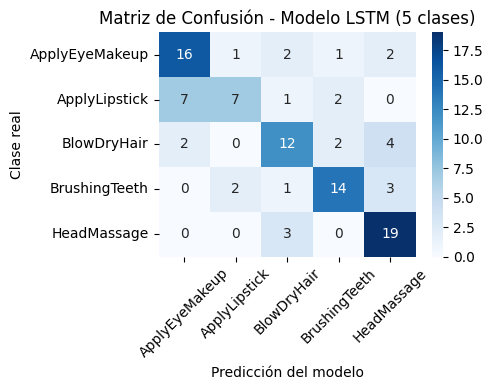

In [72]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Evaluar la precisión en el conjunto de prueba
loss_test, acc_test = model.evaluate(X_test, Y_test_enc, verbose=0)
print(f"Precisión en el conjunto de prueba: {acc_test*100:.2f}%")

# predicciones del modelo
Y_pred_probs = model.predict(X_test)
Y_pred_classes = np.argmax(Y_pred_probs, axis=1)   # índice de clase con mayor probabilidad
Y_true_classes = np.argmax(Y_test_enc, axis=1)     # etiqueta verdadera (de one-hot a índice)

# matriz de confusión
cm = confusion_matrix(Y_true_classes, Y_pred_classes)
print("Matriz de confusión (como tabla):\n", cm)

# Visualizar la matriz de confusión
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=clases_interes, yticklabels=clases_interes)
plt.xlabel("Predicción del modelo")
plt.ylabel("Clase real")
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.title("Matriz de Confusión - Modelo LSTM (5 clases)")
plt.tight_layout()
plt.show()

## Predicciones con el modelo entrenado (ejemplos e interpretación)

In [73]:
# Lista de nombres de clases para interpretación de resultados
clase_nombres = clases_interes

# Realizar predicciones en un ejemplo de cada clase en el conjunto de prueba
print("\nEjemplos de predicción en secuencias de prueba:")
for label_idx, clase in enumerate(clase_nombres):
    # buscar índice de una secuencia de prueba que corresponda a la clase actual
    indices = np.where(Y_true_classes == label_idx)[0]
    if len(indices) == 0:
        continue
    i = indices[0]
    seq = X_test[i:i+1]  # secuencia a predecir (formato batch de tamaño 1)
    true_label = Y_true_classes[i]
    pred_probs = model.predict(seq)
    pred_label = np.argmax(pred_probs, axis=1)[0]
    pred_conf = pred_probs[0][pred_label] * 100
    print(f"Secuencia {i}: Clase real = {clase_nombres[true_label]}, ",
          f"Predicción del modelo = {clase_nombres[pred_label]} ",
          f"(confianza: {pred_conf:.1f}%) - ",
          "Correcto" if pred_label == true_label else "Incorrecto")


Ejemplos de predicción en secuencias de prueba:
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
Secuencia 1: Clase real = ApplyEyeMakeup,  Predicción del modelo = ApplyEyeMakeup  (confianza: 80.4%) -  Correcto
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
Secuencia 4: Clase real = ApplyLipstick,  Predicción del modelo = ApplyLipstick  (confianza: 59.9%) -  Correcto
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
Secuencia 3: Clase real = BlowDryHair,  Predicción del modelo = BrushingTeeth  (confianza: 74.8%) -  Incorrecto
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
Secuencia 0: Clase real = BrushingTeeth,  Predicción del modelo = BrushingTeeth  (confianza: 81.1%) -  Correcto
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step
Secuencia 5: Clase real = HeadMassage,  Predicción del modelo = HeadMassage  (confianza: 49.1%) -  Correcto


## Script de inferencia para un vídeo

In [77]:
import numpy as np

def preprocess_sequence(ann, L=300):
    """
    Convierte una entrada del .pkl en una secuencia 2D fija (L, F).
    Normaliza las coordenadas y aplica padding con ceros si es necesario.
    """
    kp_seq = ann['keypoint'][0]  # (T, V, C) - tomamos la primera persona
    T, V, C = kp_seq.shape
    height, width = ann['img_shape']
    kp_seq = kp_seq.astype(np.float32)
    kp_seq[..., 0] /= width
    kp_seq[..., 1] /= height
    seq_2d = kp_seq.reshape(T, V*C)

    if T > L:
        seq_2d = seq_2d[:L]
    elif T < L:
        pad_len = L - T
        pad = np.zeros((pad_len, seq_2d.shape[1]), dtype=seq_2d.dtype)
        seq_2d = np.concatenate([seq_2d, pad], axis=0)

    return seq_2d

def predict_video(video_id, data, model, class_names=None):
    """
    Busca una entrada en data['annotations'] cuyo frame_dir contenga video_id,
    la preprocesa y devuelve predicciones (índice de clase, confianza, probs).
    """
    L = model.input_shape[1]
    for ann in data['annotations']:
        if video_id in ann['frame_dir']:
            seq_2d = preprocess_sequence(ann, L)
            seq = np.expand_dims(seq_2d, axis=0)  # (1, L, F)
            preds = model.predict(seq, verbose=0)[0]
            pred_idx = int(np.argmax(preds))
            conf = float(preds[pred_idx])
            return pred_idx, conf, preds
    raise ValueError(f"No se encontró '{video_id}' en las anotaciones")


In [80]:
# Find a valid video_id from the original data that belongs to one of the 5 classes
valid_video_id_found = None
for ann_item in data['annotations']:
    video_id_from_ann = ann_item['frame_dir']
    # Check if the video_id contains any of the interest classes
    for clase in clases_interes:
        if clase in video_id_from_ann:
            valid_video_id_found = video_id_from_ann
            break
    if valid_video_id_found:
        break

if valid_video_id_found:
    print(f"Using a valid video_id from data: {valid_video_id_found}")
    pred_idx, conf, probs = predict_video(
        video_id=valid_video_id_found,
        data=data,
        model=model,
        class_names=clases_interes,
    )
    print(f"Predicción: {clases_interes[pred_idx]} (confianza: {conf*100:.2f}%)")
else:
    print("Could not find any video_id matching the interest classes in data['annotations'].")

Using a valid video_id from data: v_ApplyEyeMakeup_g08_c01
Predicción: ApplyEyeMakeup (confianza: 87.47%)
